# Count the number of targets clustered together in Functional (CHIP-seq) or Accessible (ATAC-seq) regions

Although nucleosomes can block proteins from binding or diffusing, they are also dynamically moving along the DNA. ATAC-seq peaks can be a better indicator that within one peak, proteins can freely move and bind. Consider all CHIP-seq peaks are with ATAC-seq peaks, the functional region will be a subset of accessible region. Then, the disribution of target-cluster sizes can be compared.

In [1]:
import pandas as pd
import numpy as np
from progressbar import progressbar
from matplotlib import pyplot as plt
import pyranges as pr

In [4]:
# Read chromatin sizes from .sizes.
def readChromSize(file):
    '''
    Read chromatin sizes from .sizes.
    Input:
        file name, str
    Output:
        sizes, as a dictionary {name:size}
    '''
    sizes = {}
    with open(file, 'r') as f:
        for line in f:
            linelist = line.split()
            sizes.update({linelist[0]:int(linelist[1])})
    return sizes

# read in chromatin sizes
chromSizes = readChromSize('../../saved_data/GAGA_Genome_dm3/dm3.chrom.sizes.txt')
# read in all GAF sites along the genome
# The original GAGAG sites were obtained by igv directly. 
# However, the start site is one forward, making 6 sites covered (or this is slicing syntax)
gagag_sites = pd.read_csv("../../saved_data/GAGA_Genome_dm3/GAGAG_dm3.csv")
# read in functional region (ChipSeq), supposely, all peaks have GAGAG sites
functional = pd.read_csv('../../saved_data/GAGA_Genome_dm3/GAFChIP-Lis (Autosaved).csv')
# read in accessible region (A-tac)
accessible = pd.read_csv("../../saved_data/GAGA_Genome_dm3/LACZ_ATACseq.mRp.clN_peaks.broadPeak.liftover.csv")

In [5]:
# types of different GA sites and nucleosomes
class GA_NUC_TYPES():
    '''
    types of different GA sites and nucleosomes
    Attributes:
        chrom: name of the chromosome
        nuc_only: positions with only nucleosome
        GA_all: all gagag sites
        GA_only: positions with only gagag site
        GA_nuc: positions with both nucleosome and GA site
        freeDNA: free DNA
    '''
    def __init__(self, chrom):
        '''
        Input should be np.ndarray
        '''
        self.chrom = chrom
        self.nuc_only:list = []
        self.GA_all:list = []
        self.nuc_all:list = []
        self.GA_only:list = []
        self.GA_nuc:list = []
        self.freeDNA:list = []
        
    def _updateData(self, i, vi):
        '''
        Update the data according to the chromatin map value
        Input:
            i: index of the current position
            vi: chromatin map value at position i
            space: the space of free DNA around this site
        '''
        if vi >= 2:
            if vi == 2:
                self.nuc_only.append(i)
                self.nuc_all.append(i)
            elif vi == 3:
                self.GA_nuc.append(i)
                self.GA_all.append(i)
        else:
            if vi == 1:
                self.GA_only.append(i)
                self.GA_all.append(i)
            else:
                self.freeDNA.append(i)

# chromatin data
class CHROMO():
    '''
    chromatin data
    Attributes:
        chrom: name of the chromosome
        accessible: condition in accessible region (ATac)
        function: condition in GA functional region (ChipSeq)
        muted: neither in accessible nor functional region
    '''
    def __init__(self, chrom):
        '''
        Input should be GA_NUC_TYPES
        '''
        self.chrom = chrom
        self.accessible_only:GA_NUC_TYPES = GA_NUC_TYPES(chrom)
        self.accessible:GA_NUC_TYPES = GA_NUC_TYPES(chrom)
        self.function:GA_NUC_TYPES = GA_NUC_TYPES(chrom)
        self.muted:GA_NUC_TYPES = GA_NUC_TYPES(chrom)
        
    def getNumGA(self):
        uniqueGA = np.unique(np.concatenate([self.accessible.GA_all, 
                                             self.function.GA_all, 
                                             self.muted.GA_all]))
        return len(uniqueGA)

# find whether the position of nucleosome and gagag matches
# returns: only nucleosome, only gagag, gagag+nucleosome
def match_nucleosome_gag(
        chrom:str,  chromSizes:dict[str,int], GAGAG_all:pd.DataFrame, functional:pd.DataFrame=None, 
        accessible:pd.DataFrame=None, nucleosomes:pr.PyRanges=None, extend:int=0
    ) -> CHROMO:
    '''
    Inputs:
        chrom: name of the target chromosome
        chromSizes: size of chromosomes, dictionary {name:size}
        GA_all: all GA sites along the whole genome, read from csv file (dm3)
        GA_func: functional GA sites, pandas data frame (ChipSeq)
        accessible: accessible regions, read from csv file (Atac)
        nucleosomes: nucleosome positions of the whole genome, read from bed file
        extend: iNPS only considers the nucleosome enriched region, after extension, the 
            nucleosomal region becomes (left - extend, right + extend)
    Outputs:
        CHROMO
    '''

    # get the nucleosome position data
    if bool(nucleosomes):
        nuc = nucleosomes[nucleosomes.Chromosome == chrom].df
    else:
        nuc = pd.DataFrame(columns=['Chromosome', 'Start', 'End'])
    # get the gagag position data
    gag_all = GAGAG_all[GAGAG_all['chr'] == chrom]
    gag_func = functional[functional['chr'] == chrom]
    gag_acc = accessible[accessible['chr'] == chrom]
    # get the size of this chromosome
    size = chromSizes[chrom]
    
    # the coordinate of the first base in bed files is 0
    
    print(f'{chrom}: classifying bases...', end=' ')
    chr_map = np.zeros(size)
    # chr_map = 10*m + n, for example, when m=1, n=2, chr_map=12
    # n = 0: no GA sites or nucleosomes, 
    # n = 1: GA site only
    # n = 2: nucleosome only
    # n = 3: GA site with nucleosome
    # m = 0: not functional or accessible region
    # m = 1: functional region
    # m = 2: accessible region
    # m = 3: both functional and accessible region
    ## label all GA sites
    for i in range(gag_all.shape[0]):
        chr_map[gag_all['start'].iloc[i] : gag_all['start'].iloc[i]+5] = 1 
    ## label functional regions
    thisPeak = ''
    for i in range(gag_func.shape[0]):
        if thisPeak == gag_func.iloc[i]['peak']:
            pass
        else:
            # read in peak position
            thisPeak = gag_func.iloc[i]['peak']
            # label ChipSeq peak
            chr_map[gag_func['start'].iloc[i] : gag_func['end'].iloc[i]] += 10
    ## label accessible regions
    for i in range(gag_acc.shape[0]):
        for j in range(gag_acc['Start'].iloc[i], gag_acc['End'].iloc[i]):
            if chr_map[j] < 20: chr_map[j] += 20
    ## label nucleosome positions
    for i in range(nuc.shape[0]):
        chr_map[nuc['Start'][i]-extend:nuc['End'][i]+extend] += 2
        
    
    if max(chr_map) > 33:
        print('Overlap!!!')

    print('storing classified data...', end=' ')
    chromo = CHROMO(chrom)
    for i, vi in enumerate(chr_map):
        if vi >=30:
            # both functional and accessible region
            chromo.function._updateData(i, vi-30)
            chromo.accessible._updateData(i, vi-30)
        elif vi >= 20:
            # accessible region
            chromo.accessible._updateData(i, vi-20)
            chromo.accessible_only._updateData(i, vi-20)
        elif vi >= 10:
            # functional region
            chromo.function._updateData(i, vi-10)
            # a functional region should be accessible
            chromo.accessible._updateData(i, vi-10)
        else:
            # not functional or accessible region.
            chromo.muted._updateData(i, vi)
            
    print('finish!')
    
    return chromo

In [6]:
data_chr = {}
for chrom in np.unique(functional['chr']):
    data_chr.update(
        {
            chrom:match_nucleosome_gag(
                chrom, chromSizes, gagag_sites, functional, accessible,
            )
        }
    )

chr2L: classifying bases... storing classified data... finish!
chr2R: classifying bases... storing classified data... finish!
chr2RHet: classifying bases... storing classified data... finish!
chr3L: classifying bases... storing classified data... finish!
chr3LHet: classifying bases... storing classified data... finish!
chr3R: classifying bases... storing classified data... finish!
chr3RHet: classifying bases... storing classified data... finish!
chr4: classifying bases... storing classified data... finish!
chrM: classifying bases... storing classified data... finish!
chrU: classifying bases... storing classified data... finish!
chrUextra: classifying bases... storing classified data... finish!
chrX: classifying bases... storing classified data... finish!


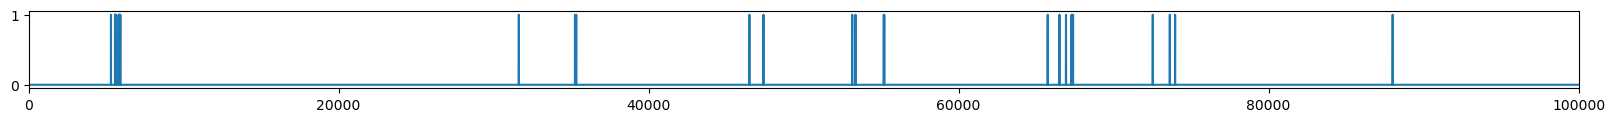

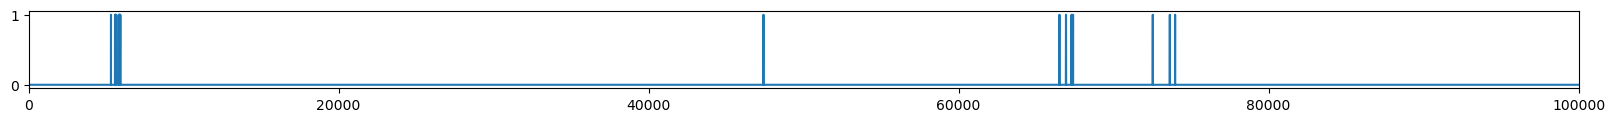

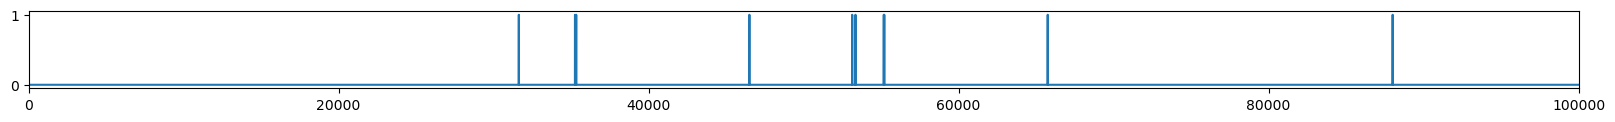

In [7]:
xlim = [0, 1e5]
plt.figure(figsize=(20,1))
chromo = 'chr2L'
chrMap = np.zeros(chromSizes[chromo])
chrMap[data_chr[chromo].accessible.GA_all] = 1
plt.xlim(xlim)
plt.plot(chrMap)
plt.show()
plt.figure(figsize=(20,1))
chromo = 'chr2L'
chrMap = np.zeros(chromSizes[chromo])
chrMap[data_chr[chromo].function.GA_all] = 1
plt.xlim(xlim)
plt.plot(chrMap)
plt.show()
plt.figure(figsize=(20,1))
chromo = 'chr2L'
chrMap = np.zeros(chromSizes[chromo])
chrMap[data_chr[chromo].accessible_only.GA_all] = 1
plt.xlim(xlim)
plt.plot(chrMap)
plt.show()

In [8]:
# Calculate sizes of GA site clusters
def clusterSizes(acc_map:np.ndarray, DNA_map:np.ndarray, gapsize:int, ifprint):
    # calculate cluster sizes
    if ifprint: print('calculating cluster sizes...', end=' ')
    cluster_sizes = []
    clusterSizes_newSegment = []
    gagag_start = -1
    gagag_end = -1
    for i, vi in enumerate(acc_map):
        if vi == 0:
            if gagag_start != -1:
                clusterSizes_newSegment.append(np.sum(DNA_map[gagag_start:gagag_end+1]==2))
                gagag_start = -1
                gagag_end = -1
            cluster_sizes.extend(clusterSizes_newSegment)
            clusterSizes_newSegment = []
        else:
            if DNA_map[i] == 2:
                # this belongs to a GAGAG site
                if gagag_start == -1:
                    gagag_start = i
                    gagag_end = i
                else:
                    gagag_end = i
            else:
                # this site is not asigned as a GAGAG site
                if gagag_start != -1:
                    # there is a GAGAG site before
                    if i <= gagag_end + gapsize:
                        if DNA_map[i:gagag_end+gapsize+1].all() <= 1:
                            # this is a real gap or end of a segment
                            clusterSizes_newSegment.append(np.sum(DNA_map[gagag_start:gagag_end+1]==2))
                            gagag_start = -1
                            gagag_end = -1
                        else:
                            # this is a fake gap inside consecutive GAGAG sites
                            pass
                    else:
                        pass

    if ifprint: print('finished!', end='\t')
    return [size for size in cluster_sizes if size >= 5]


# Each GA site has a cluster size which is the maximum cluster around it
def chromatinClusterSizes(chromSize, GAGAG_sites:CHROMO, gapsize=2, ifprint=True):
    '''
    Calculate sizes of gagag site clusters. Each cluster should be within a peak of ATAC-seq and separated no more than gapsize.
    Input:
        chromSize, size of this chromatin
        GAGAG_sites, GAGA sites on a chromatin within one region
        window, window size in unit of nt, default=1000
    Output:
        cluster_sizes, as np.ndarray
    '''
    # label accessible regions
    acc_map = np.zeros(chromSize)
    acc_map[GAGAG_sites.accessible.freeDNA] = 1
    acc_map[GAGAG_sites.accessible.GA_all] = 2
    # label accessible only regions
    acc_only_map = np.zeros(chromSize)
    acc_only_map[GAGAG_sites.accessible_only.GA_all] = 2
    # label all GAGAG sites in functional regions
    func_map = np.zeros(chromSize)
    func_map[GAGAG_sites.function.GA_all] = 2


    # calculate cluster sizes
    if ifprint: print('functional:', end=' ')
    clusterSizes_functional = clusterSizes(acc_map, func_map, gapsize, ifprint)
    if ifprint: print('accesible:', end=' ')
    clusterSizes_accessible = clusterSizes(acc_map, acc_only_map, gapsize, ifprint)
    if ifprint: print('')

    return clusterSizes_functional, clusterSizes_accessible

def findClusters(chromSize_dict=chromSizes, GAGAG_sites_dict=data_chr, gapsize=2, ifprint=True):
    '''
    Find clusters of GAGAG sites in each chromosome
    Input:
        chromSize_dict, dictionary of chromosome sizes {chrom:size}
        GAGAG_sites_dict, dictionary of GAGAG sites on each chromosome {chrom:GAGAG_sites}
        gapsize, maximum gap size between two GAGAG sites, default=2
    Output:
        cluster_sizes, dictionary of cluster sizes {chrom:cluster_sizes}
    '''
    cluster_sizes_func = {}
    cluster_sizes_acc = {}
    for chrom in data_chr.keys():
        if ifprint: print(f'{chrom}:', end=' ')
        func, acc = chromatinClusterSizes(chromSize_dict[chrom], GAGAG_sites_dict[chrom], gapsize, ifprint)
        cluster_sizes_func.update({chrom:func})
        cluster_sizes_acc.update({chrom:acc})
    return cluster_sizes_func, cluster_sizes_acc



In [9]:
cluster_sizes_func, cluster_sizes_acc = findClusters(gapsize=420)

chr2L: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chr2R: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chr2RHet: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chr3L: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chr3LHet: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chr3R: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chr3RHet: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chr4: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chrM: functional: calculating cluster sizes... finished!	accesible: calculating cluster sizes... finished!	
chrU: functi

In [10]:
for chromo in data_chr.keys():
    print(chromo)
    print('accessible:', end='\t')
    nClusChromo_acc = np.array(cluster_sizes_acc[chromo])/5
    for nsize in np.unique(nClusChromo_acc):
        print(f'{nsize}: {np.sum(nClusChromo_acc==nsize)/nClusChromo_acc.shape[0]:.2e}', end=' ')
    print('')
    print('functional:', end='\t')
    nClusChromo_func = np.array(cluster_sizes_func[chromo])/5
    for nsize in np.unique(nClusChromo_func):
        print(f'{nsize}: {np.sum(nClusChromo_func==nsize)/nClusChromo_func.shape[0]:.2e}', end=' ')
    print('')

chr2L
accessible:	1.0: 9.98e-01 2.0: 1.26e-03 3.0: 4.19e-04 
functional:	1.0: 9.96e-01 2.0: 3.53e-03 
chr2R
accessible:	1.0: 9.96e-01 2.0: 3.55e-03 
functional:	1.0: 9.96e-01 2.0: 4.14e-03 
chr2RHet
accessible:	
functional:	1.0: 1.00e+00 
chr3L
accessible:	1.0: 9.97e-01 2.0: 3.27e-03 
functional:	1.0: 9.95e-01 2.0: 5.03e-03 
chr3LHet
accessible:	
functional:	1.0: 1.00e+00 
chr3R
accessible:	1.0: 9.98e-01 2.0: 1.94e-03 
functional:	1.0: 9.96e-01 2.0: 4.06e-03 3.0: 2.14e-04 
chr3RHet
accessible:	
functional:	1.0: 1.00e+00 
chr4
accessible:	1.0: 1.00e+00 
functional:	1.0: 1.00e+00 
chrM
accessible:	
functional:	
chrU
accessible:	
functional:	1.0: 1.00e+00 
chrUextra
accessible:	
functional:	1.0: 9.83e-01 2.0: 8.71e-03 3.0: 4.36e-03 9.0: 2.18e-03 15.0: 2.18e-03 
chrX
accessible:	1.0: 9.97e-01 2.0: 2.65e-03 
functional:	1.0: 9.94e-01 2.0: 5.88e-03 


In [11]:
for chromo in data_chr.keys():
    print(chromo)
    print('accessible:', end='\t')
    nClusChromo_acc = np.array(cluster_sizes_acc[chromo])/5
    for nsize in np.unique(nClusChromo_acc):
        print(f'{nsize}: {np.sum(nClusChromo_acc==nsize)}', end=' ')
    print('')
    print('functional:', end='\t')
    nClusChromo_func = np.array(cluster_sizes_func[chromo])/5
    for nsize in np.unique(nClusChromo_func):
        print(f'{nsize}: {np.sum(nClusChromo_func==nsize)}', end=' ')
    print('')

chr2L
accessible:	1.0: 2383 2.0: 3 3.0: 1 
functional:	1.0: 3383 2.0: 12 
chr2R
accessible:	1.0: 2523 2.0: 9 
functional:	1.0: 3851 2.0: 16 
chr2RHet
accessible:	
functional:	1.0: 25 
chr3L
accessible:	1.0: 2744 2.0: 9 
functional:	1.0: 3960 2.0: 20 
chr3LHet
accessible:	
functional:	1.0: 35 
chr3R
accessible:	1.0: 3092 2.0: 6 
functional:	1.0: 4655 2.0: 19 3.0: 1 
chr3RHet
accessible:	
functional:	1.0: 50 
chr4
accessible:	1.0: 181 
functional:	1.0: 87 
chrM
accessible:	
functional:	
chrU
accessible:	
functional:	1.0: 78 
chrUextra
accessible:	
functional:	1.0: 451 2.0: 4 3.0: 2 9.0: 1 15.0: 1 
chrX
accessible:	1.0: 1880 2.0: 5 
functional:	1.0: 4906 2.0: 29 


In [12]:
# seleChromo = ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX']
seleChromo = cluster_sizes_func.keys()
nClusterList_func = np.concatenate([cluster_sizes_func[key] for key in seleChromo])/5
nClusterList_acc = np.concatenate([cluster_sizes_acc[key] for key in seleChromo])/5
print(np.mean(nClusterList_func), np.mean(nClusterList_acc))

1.0059297692949134 1.0026488002492988


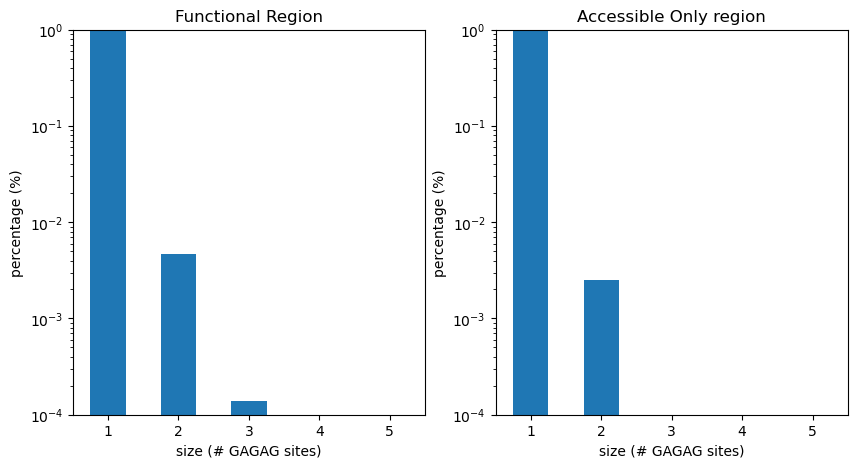

In [13]:
plt.subplots(nrows=1, ncols=2, figsize=(10,5))
ylim = [1e-4,1]
xmax = 5
xlim = [0.5, xmax+0.5]
xticks = np.arange(1, xmax+0.5, 1)
histBins = np.arange(0.5, xmax+1.5, 1)
rwidth = 0.5

plt.subplot(121)
plt.hist(nClusterList_func, histBins, density=True, rwidth=rwidth)
plt.semilogy()
# plt.legend()
plt.title('Functional Region')
plt.xlabel('size (# GAGAG sites)')
plt.ylabel('percentage (%)')
plt.xticks(xticks)
plt.xlim(xlim)
plt.ylim(ylim)
# plt.yticks([1e0, 1e-1, 1e-2, 1e-3, 1e-4], [100, 10, 1, 0.1, 0.01])


plt.subplot(122)
plt.hist(nClusterList_acc, histBins, density=True, rwidth=rwidth)
plt.semilogy()
# plt.legend()
plt.title('Accessible Only region')
plt.xlabel('size (# GAGAG sites)')
plt.ylabel('percentage (%)')
plt.xticks(xticks)
plt.xlim(xlim)
plt.ylim(ylim)
# plt.yticks([1e0, 1e-1, 1e-2, 1e-3, 1e-4], [100, 10, 1, 0.1, 0.01])

plt.show()

# GAGAG motif distances

In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pyranges as pr
from tqdm import tqdm
import seaborn as sns

# Consider nucleosomes

In [2]:
# GAF motifs from ChIP-seq
ALL_motifs = pd.read_csv('./GAGAG_dm3.csv')
# nucleosome positions
nucleosomes = pr.read_bed('./dmNuc0210501.nucleosome.iNPSPeak.bed')

In [5]:
from collections import Counter

def find_motifs_between_dyads(chrom, motif):
    """
    Identify the distribution of the number of complete motifs between nucleosome dyads.
    
    Parameters:
    chrom (list or np.array): {0, 1} sequence where 0 represents free DNA and 1 represents dyad of nucleosome.
    motif (pd.DataFrame): DataFrame with "start" and "end" columns indicating motif positions.

    Returns:
    dict: Distribution of the number of motifs between dyads.
    """
    
    # Find indices of dyads
    dyad_indices = []
    for i, row in chrom.df.iterrows():
        if row.Name.split(':')[1].strip() == 'MainPeak':
            midleft = int(np.floor((row['Start'] + row['End'])/2))
            dyad_indices.append(midleft)

    # Ensure dyad_indices is sorted
    dyad_indices.sort()
    
    # Count complete motifs between consecutive dyads
    motif_counts = []
    for i in range(len(dyad_indices) - 1):
        start_dyad = dyad_indices[i]
        end_dyad = dyad_indices[i + 1]
        
        # Count motifs completely between the current dyads
        count = sum((motif["start"] > start_dyad) & (motif["end"] < end_dyad))
        motif_counts.append(count)

    # Calculate the distribution of motif counts
    distribution = dict(Counter(motif_counts))
    
    return distribution

# Example usage
distributions_all = []
for chrom in ['chr2L', 'chr2R', 'chr3L', 'chr3R', 'chr4', 'chrX', 'chrY']:
    print(chrom, end='... ')
    distributions_all.append(find_motifs_between_dyads(
        nucleosomes[chrom], ALL_motifs[ALL_motifs['chr']==chrom]
    ))
print('end.')
# print(distribution)


chr2L... chr2R... chr3L... chr3R... chr4... chrX... chrY... end.


In [31]:
distribution_all_combined = {}
for distribution in distributions_all:
    for count in distribution.keys():
        if count > 0:
            if count in distribution_all_combined:
                distribution_all_combined[count] += distribution[count]
            else:
                distribution_all_combined[count] = distribution[count]

threshold = 8
for count in list(distribution_all_combined.keys()):
    if count > threshold:
        distribution_all_combined[threshold] += distribution_all_combined.pop(count)

In [32]:
def plotHeader(
    scale=1.0, fixSize=True, sizeX=5, sizeY=5,
    lgdLoc=[0.55,0.00], lgdFontSize=22, lgdHandleL=0.3, 
    lgdTitle='', lgdTtlFontSize=22,
    labelFontSize=20, tickFontSize=27, 
    tickL=15, tickW=2, spineLineW=2
):
    labelfont = {'fontsize':labelFontSize*scale}
    tickfont = {'fontsize':tickFontSize*scale}
    legend = {'fontsize':lgdFontSize*scale, 'loc':lgdLoc, 'handlelength':lgdHandleL*scale, 
              'title':lgdTitle, 'title_fontsize':lgdTtlFontSize*scale,
             'framealpha':0.0}
    if fixSize:
        fig = plt.figure(figsize=(sizeX*scale,sizeY*scale))
        ax = fig.add_subplot(111)
    else:
        ax = plt.gca()
    plt.tick_params(length=tickL*scale, width=tickW*scale)
    for axis in ['top', 'bottom', 'left', 'right']:
        ax.spines[axis].set_linewidth(spineLineW*scale)  # change width
    colors = [
        'tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 
        'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'
    ]
    linsStyles = ['-', '--']
    return ax, colors, linsStyles, legend, labelfont, tickfont, 0.6022 # C0, nm^-3 -> M

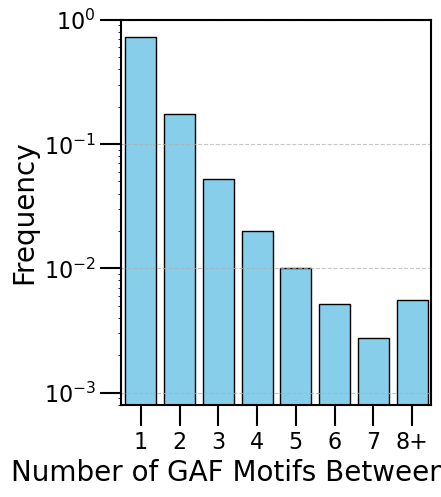

In [36]:
counts = np.array(list(distribution_all_combined.keys()))
frequencies = np.array(list(distribution_all_combined.values()))


ax, colors, linsStyles, legend, labelfont, tickfont, C0 = plotHeader(
    sizeX=4, sizeY=5, spineLineW=1.5, tickW=1.5, tickFontSize=16, labelFontSize=20, 
)

# Create a bar plot
plt.bar(counts, frequencies/np.sum(frequencies), color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Number of GAF Motifs Between Dyads', **labelfont)
plt.ylabel('Frequency', **labelfont)
plt.semilogy()

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(range(1,9), ['1', '2', '3', '4', '5', '6', '7', '8+'], **tickfont)
plt.yticks(**tickfont)
plt.xlim([0.5,8.5])
plt.ylim([0.8e-3,1e0])
plt.show()

In [34]:
frequencies[counts.argsort()]

array([77898, 18649,  5547,  2151,  1073,   551,   296,   596])

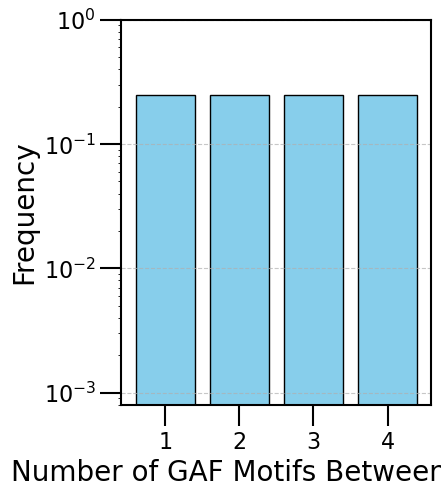

In [40]:
counts = np.array(list(distribution_all_combined.keys()))
frequencies = np.array(list(distribution_all_combined.values()))


ax, colors, linsStyles, legend, labelfont, tickfont, C0 = plotHeader(
    sizeX=4, sizeY=5, spineLineW=1.5, tickW=1.5, tickFontSize=16, labelFontSize=20, 
)

# Create a bar plot
plt.bar([1,2,3,4], [0.25, 0.25, 0.25, 0.25], color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Number of GAF Motifs Between Dyads', **labelfont)
plt.ylabel('Frequency', **labelfont)
plt.semilogy()

# Show grid and plot
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(**tickfont)
plt.yticks(**tickfont)

plt.ylim([0.8e-3,1e0])
plt.show()